# Import dump into MySQL with Python

## Imports and paths

In [5]:
import os
from pathlib import Path
import re
import pandas as pd
import mysql.connector as mysql
import matplotlib.pyplot as plt

In [2]:
home_path = str(Path.home())
os.chdir(home_path + '/git/predwikt/notebooks')

In [9]:
dump_url = '../data/raw/enwiki-latest-categorylinks.sql'
db_name = 'latest_categorylinks'

## Starting / Restarting MariaDB after it dies:

### Initialize in bash

**bash**
```bash
service mysqld start
netstat -lnp | grep mysql
```
(I had to use mysqld not mysql: [link](https://stackoverflow.com/questions/11990708/error-cant-connect-to-local-mysql-server-through-socket-var-run-mysqld-mysq))

### ***If no db:*** Drop the incomplete table and put back schema

#### Drop the incomplete table

#### Put create_table_str into memory

#### Recreate the table schema

### Starting mysql.connect

#### Get passwords for mysql.connect

In [3]:
mysql_superuser = 'root'
# mysql_su_pass = input(f'Enter the MySQL password for user {mysql_superuser}: ')
mysql_defaultuser = 'bhrdwj'
# mysql_def_pass = input(f'Enter the MySQL password for user {mysql_defaultuser}: ')

#### Connect mysql.connect and initialize cursor

In [42]:
db_mysql = mysql.connect(
    host = "localhost",
    user = "root",
    passwd = mysql_su_pass,
    #database='latest_page' # not the first time around
)
cur_mysql = db_mysql.cursor()

#### Close connection

### Check connection

#### Check current user and schema

In [47]:
cur_mysql.execute('select user();')
print(cur_mysql.fetchall())
cur_mysql.execute('select database();')
print(cur_mysql.fetchall())
cur_mysql.execute('show tables;')
print(cur_mysql.fetchall())

[('root@localhost',)]
[('latest_categorylinks',)]
[('categorylinks',)]


In [49]:
cur_mysql.execute('DESCRIBE categorylinks;')
schema = pd.DataFrame(cur_mysql.fetchall(), columns=['Field','Type','Null','Key','Default','Extra'])
schema

,Field,Type,Null,Key,Default,Extra
0,cl_from,int(8) unsigned,NO,PRI,0,
1,cl_to,varbinary(255),NO,PRI,,
2,cl_sortkey,varbinary(230),NO,,,
3,cl_timestamp,timestamp,NO,,current_timestamp(),on update current_timestamp()
4,cl_sortkey_prefix,varbinary(255),NO,,,
5,cl_collation,varbinary(32),NO,MUL,,
6,cl_type,"enum('page','subcat','file')",NO,,page,


#### Check if table is empty

In [51]:
cur_mysql.execute('SELECT EXISTS(SELECT 1 FROM categorylinks);')
cur_mysql.fetchall()

[(0,)]

## Get params of sql dump

### Define EDA functions

#### Function to open a dump

- ***ONLY USE THIS IN*** ```with open_dump(dump_url) as f:``` ***CONTEXT***
- (as is done in function `get_line_lengths`)


In [10]:
def open_dump(url):
    return open(url, mode='r', encoding='UTF_8', errors='backslashreplace')

#### Define a function to get line lengths

In [11]:
def get_line_lengths(dump_url):
    line_lengths = []
    with open_dump(dump_url) as f:
        for line in f:
            line_lengths.append(len(line))
    return line_lengths

#### Define a function to plot line lengths

In [15]:
def plot_line_lengths(ll):
    s = pd.Series(ll, name='line_lengths')
    fig = plt.figure(figsize=(6,3))
    ax = plt.gca()
    s.plot(ax=ax)
    ax.set_xticks([0, len(line_lengths)])
    ax.set_xlabel('rows of file')
    ax.set_ylabel('line length')
    plt.show()

#### Define a function to get a contiguous slice of rows of dump file

In [22]:
def get_those_rows(start, end, dump_url):
    those_rows = []
    with open_dump(dump_url) as f:
        for i in range(end):
            if i < start:
                f.readline()
            elif i >= start:
                those_rows.append(f.readline())
            else:
                break
    return those_rows

### Check dump params

#### Get line lengths and dump length

In [13]:
line_lengths = get_line_lengths(dump_url)
dump_length = len(line_lengths)

#### Plot line lengths

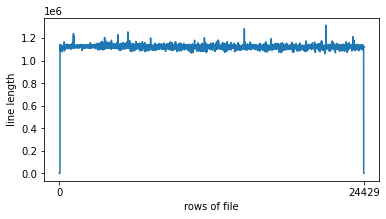

In [16]:
plot_line_lengths(line_lengths)

#### Get start/end row numbers for headers, data, footers

In [17]:
i=0
while line_lengths[i] < 10**4: i+=1
head_last_rownum = i-1
data_first_rownum = i

In [18]:
i=dump_length-100
while line_lengths[i] > 10**4: i+=1
data_last_rownum = i-1
foot_first_rownum = i

### Show dumpfile metadata

#### Key line numbers

In [26]:
(0, head_last_rownum, data_first_rownum, 
    data_last_rownum, foot_first_rownum, dump_length)

(0, 43, 44, 24416, 24417, 24429)

#### Headers

In [24]:
headers = ''.join(get_those_rows(0, head_last_rownum+1, dump_url))
print(headers)

-- MySQL dump 10.19  Distrib 10.3.31-MariaDB, for debian-linux-gnu (x86_64)
--
-- Host: 10.64.48.13    Database: enwiki
-- ------------------------------------------------------
-- Server version	10.4.21-MariaDB-log

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `categorylinks`
--

DROP TABLE IF EXISTS `categorylinks`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_set_clien

#### Footers

In [30]:
footers = ''.join(get_those_rows(foot_first_rownum, dump_length, dump_url))

In [31]:
print(footers)

/*!40000 ALTER TABLE `categorylinks` ENABLE KEYS */;
/*!40103 SET TIME_ZONE=@OLD_TIME_ZONE */;

/*!40101 SET SQL_MODE=@OLD_SQL_MODE */;
/*!40014 SET FOREIGN_KEY_CHECKS=@OLD_FOREIGN_KEY_CHECKS */;
/*!40014 SET UNIQUE_CHECKS=@OLD_UNIQUE_CHECKS */;
/*!40101 SET CHARACTER_SET_CLIENT=@OLD_CHARACTER_SET_CLIENT */;
/*!40101 SET CHARACTER_SET_RESULTS=@OLD_CHARACTER_SET_RESULTS */;
/*!40101 SET COLLATION_CONNECTION=@OLD_COLLATION_CONNECTION */;
/*!40111 SET SQL_NOTES=@OLD_SQL_NOTES */;

-- Dump completed on 2021-11-20  9:18:15



## Import one line of SQL dump with mysql.connect

### Check current mysql table

#### Check length of mysql table

In [89]:
cur_mysql.execute('SELECT COUNT(*) FROM page;')

cur_mysql.fetchall()

[(8671392,)]

Interesting that 
- the max page_id used to be equal to the count of page_id's.
- but now they're very different
Therefore,
- I am going to try abandoning this python/mysql.connector import process
- and go back to a one-command bash-based import

In [91]:
start_idx = data_first_rownum + 610
end_idx   = start_idx + 92

### Populate one dumpline into mysql very carefully

#### Get the next sql dump line

***COULDN'T GET last_dumpline_primary_key*** 
- some values have parentheses inside them.  
- so I need to do a better regex search for last_dumpline_primarykey:
    - I should only find a ( paren that isn't inside quotes.

In [78]:
prev_line = get_those_rows(start_idx-1, start_idx, dump_url)[0]
last_record_string = re.search(r'(\([^\(]*)(?:;\n)$', prev_line[-500:]).groups()[0]
last_dumpline_primarykey = int(re.search(r'(?:\()(\d*)',last_record_string).groups()[0])
last_dumpline_primarykey

8569499

In [79]:
prev_line[-500:]

"t',NULL),(8569495,3,'12.155.13.9','',0,0,0.142320634422,'20211008194424','20201027154019',717010582,6,'wikitext',NULL),(8569497,1,'Lolicon/Archive_006','',1,1,0.765643552338,'20211007031516','20191013083751',96004654,36,'wikitext',NULL),(8569498,3,'Fergielover895','',0,0,0.7459912645590001,'20200422090641','20201005154837',99473117,3142,'wikitext',NULL),(8569499,0,'Friedrich,_Prince_of_Waldeck_and_Pyrmont','',0,0,0.883677767656,'20211031062823','20211029193808',1020397979,6693,'wikitext',NULL);\n"

#### Get final primary key value of mysql table

In [90]:
cur_mysql.execute('SELECT page_id FROM page ORDER BY page_id DESC LIMIT 1;')
last_mysql_primarykey = cur_mysql.fetchall()[0][0]
last_mysql_primarykey

13880355

# Check if there's a primary key match

*The latest primary key of the mysql table should match the last primary key of the previous sql dump line.*

In [42]:
last_dumpline_primarykey == last_mysql_primarykey

False

### Populate mysql table with dumpfile lines